По примеру https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/addition_rnn.ipynb


**Замечательный пример использования и применимости seq2seq модели**

# Sequence to sequence learning for performing number addition

**Author:** [Smerity](https://twitter.com/Smerity) and others<br>
**Date created:** 2015/08/17<br>
**Last modified:** 2020/04/17<br>
**Description:** A model that learns to add strings of numbers, e.g. "535+61" -> "596".

## Introduction

In this example, we train a model to learn to add two numbers, provided as strings.

**Example:**

- Input: "535+61"
- Output: "596"

Input may optionally be reversed, which was shown to increase performance in many tasks
 in: [Learning to Execute](http://arxiv.org/abs/1410.4615) and
[Sequence to Sequence Learning with Neural Networks](

 http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)

Theoretically, sequence order inversion introduces shorter term dependencies between
 source and target for this problem.

**Results:**

For two digits (reversed):

+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs

Three digits (reversed):

+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs

Four digits (reversed):

+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs

Five digits (reversed):

+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs


## Setup


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS


## Generate the data


In [ ]:

class CharacterTable:
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """

    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)



Из похожего примера  https://github.com/Vishwa22/Calculator-using-Seq2Seq-model/blob/master/Arithmetic_calculations.md
графическое пояснение (в этом новом примере - различная длина цифровых последовательностей и есть ограничивающие и заполняющие символы - на рисунке понятно

Our input comprises of integers ranging from 0 to 9 and any arithmetic operator * + -. 

These are called symbols. So we will create a vocabulory which comprises of above symbols and also some extra symbols like "$", "^", "#".

- '^' symbol will be passed to the network to indicate the beginning of the decoding procedure.
- '$' symbol will be used to indicate the end of a string, both for input and output sequences.
- '#' symbol will be used as a padding character to make lengths of all strings equal within one training batch.)
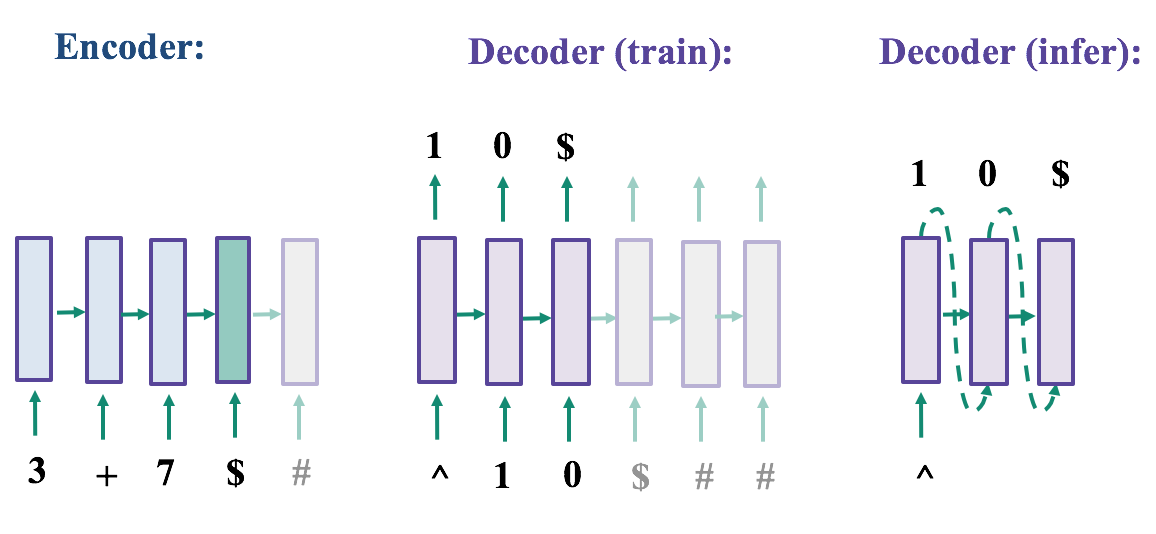

In [ ]:

# All the numbers, plus sign and space for padding.
chars = "0123456789+ "
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print("Generating data...")
while len(questions) < TRAINING_SIZE:
    f = lambda: int(
        "".join(
            np.random.choice(list("0123456789"))
            for i in range(np.random.randint(1, DIGITS + 1))
        )
    )
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = "{}+{}".format(a, b)
    query = q + " " * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += " " * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print("Total questions:", len(questions))


Generating data...
Total questions: 50000


In [ ]:
q = [q[::-1]for q in questions[:10]]
print(questions[:10])
print("Revers string:")
print(q)
print(expected[:10])

['  662+5', '    2+8', '  18+06', '    0+2', '  435+1', '   0+52', '   8+24', '   5+05', '    5+8', '864+299']
Revers string:
['5+266  ', '8+2    ', '60+81  ', '2+0    ', '1+534  ', '25+0   ', '42+8   ', '50+5   ', '8+5    ', '992+468']
['271 ', '10  ', '141 ', '2   ', '535 ', '25  ', '50  ', '55  ', '13  ', '1460']


## Vectorize the data


In [ ]:
print("Vectorization...")
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
# уберм пока
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)


Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


In [ ]:
i = np.random.randint(0, len(x_train))
print(i)
# REVERSE
#print(x_train[0][::-1])
#print(y_train[0][::-1])
print('chars = "0123456789+ "')
print(ctable.indices_char)
print(ctable.char_indices)
chars2 = [ch + " " for ch in list(ctable.char_indices.keys())]
print(" ", chars2)
print(x_train[i][::-1]) # reverse представление
print("'", ctable.decode(x_train[i])[::-1],"'", sep="")  # reverse представление
print(y_train[i])
print("'", ctable.decode(y_train[i]),"'", sep="")  


29184
chars = "0123456789+ "
{0: ' ', 1: '+', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9'}
{' ': 0, '+': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}
  ['  ', '+ ', '0 ', '1 ', '2 ', '3 ', '4 ', '5 ', '6 ', '7 ', '8 ', '9 ']
[[False False False False False False False False  True False False False]
 [False False False False False False  True False False False False False]
 [False  True False False False False False False False False False False]
 [False False False False False  True False False False False False False]
 [False False False False False  True False False False False False False]
 [False False False False False False False False False  True False False]
 [ True False False False False False False False False False False False]]
'64+337 '
[[False False False False False False  True False False False False False]
 [False False  True False False False False False False False False False]
 [False Fals

## Build the model


In [ ]:
print("Build model...")
num_layers = 1  # Try to add more LSTM layers!

model = keras.Sequential()
# "Encode" the input sequence using a LSTM, producing an output of size 128.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(layers.LSTM(128, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(num_layers):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(layers.LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.Dense(len(chars), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
dense (Dense)                (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


## Train the model


In [ ]:
epochs = 30
batch_size = 32


# Train the model each generation and show predictions against the validation
# dataset.
for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=(x_val, y_val),
    )
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = np.argmax(model.predict(rowx), axis=-1)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print("Q", q[::-1] if REVERSE else q, end=" ")
        print("T", correct, end=" ")
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)



Iteration 1
1407/1407 [==============================] - 26s 16ms/step - loss: 1.7614 - accuracy: 0.3560 - val_loss: 1.5561 - val_accuracy: 0.4173
Q 825+79  T 904  ☒ 872 
Q 69+774  T 843  ☒ 874 
Q 69+249  T 318  ☒ 300 
Q 9+327   T 336  ☒ 333 
Q 316+756 T 1072 ☒ 100 
Q 374+513 T 887  ☒ 900 
Q 929+117 T 1046 ☒ 100 
Q 422+802 T 1224 ☒ 1009
Q 227+41  T 268  ☒ 377 
Q 294+16  T 310  ☒ 232 

Iteration 2
1407/1407 [==============================] - 22s 16ms/step - loss: 1.3358 - accuracy: 0.5004 - val_loss: 1.1724 - val_accuracy: 0.5651
Q 726+604 T 1330 ☒ 1377
Q 35+378  T 413  ☒ 473 
Q 9+944   T 953  ☑ 953 
Q 850+402 T 1252 ☒ 1277
Q 43+969  T 1012 ☒ 993 
Q 329+68  T 397  ☒ 490 
Q 728+267 T 995  ☒ 100 
Q 75+334  T 409  ☒ 483 
Q 775+57  T 832  ☒ 830 
Q 907+9   T 916  ☒ 900 

Iteration 3
1407/1407 [==============================] - 23s 16ms/step - loss: 1.0260 - accuracy: 0.6191 - val_loss: 0.9394 - val_accuracy: 0.6484
Q 252+1   T 253  ☒ 259 
Q 711+484 T 1195 ☒ 1190
Q 451+291 T 742  ☒ 637 
Q 12

You'll get to 99+% validation accuracy after ~30 epochs.


## Build the model v2  
- 2 layers of LSTM (return_sequences=True)


In [ ]:
print("Build model...")
num_layers = 2  

model = keras.Sequential()
# "Encode" the input sequence using a LSTM, producing an output of size 128.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(layers.LSTM(128, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(num_layers):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(layers.LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.Dense(len(chars), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
dense_1 (Dense)              (None, 4, 12)             1548      
Total params: 336,908
Trainable params: 336,908
Non-trainable params: 0
_________________________________________________________________


## Train the model


In [ ]:
epochs = 30
batch_size = 32


# Train the model each generation and show predictions against the validation
# dataset.
for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=(x_val, y_val),
    )
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = np.argmax(model.predict(rowx), axis=-1)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print("Q", q[::-1] if REVERSE else q, end=" ")
        print("T", correct, end=" ")
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)



Iteration 1
1407/1407 [==============================] - 37s 23ms/step - loss: 1.7864 - accuracy: 0.3446 - val_loss: 1.5834 - val_accuracy: 0.4050
Q 8+94    T 102  ☒ 109 
Q 549+73  T 622  ☒ 706 
Q 3+861   T 864  ☒ 705 
Q 71+646  T 717  ☒ 805 
Q 89+903  T 992  ☒ 1009
Q 76+42   T 118  ☒ 119 
Q 0+638   T 638  ☒ 609 
Q 287+59  T 346  ☒ 455 
Q 19+284  T 303  ☒ 315 
Q 592+734 T 1326 ☒ 1404

Iteration 2
1407/1407 [==============================] - 32s 23ms/step - loss: 1.3591 - accuracy: 0.4856 - val_loss: 1.1747 - val_accuracy: 0.5628
Q 19+796  T 815  ☒ 723 
Q 33+77   T 110  ☒ 122 
Q 829+288 T 1117 ☒ 1122
Q 86+926  T 1012 ☒ 101 
Q 847+353 T 1200 ☒ 1122
Q 27+690  T 717  ☒ 723 
Q 385+929 T 1314 ☒ 1322
Q 340+944 T 1284 ☒ 1222
Q 491+731 T 1222 ☑ 1222
Q 8+681   T 689  ☒ 686 

Iteration 3
1407/1407 [==============================] - 32s 23ms/step - loss: 1.0504 - accuracy: 0.6014 - val_loss: 0.9185 - val_accuracy: 0.6538
Q 97+609  T 706  ☒ 676 
Q 695+516 T 1211 ☒ 1225
Q 158+0   T 158  ☒ 159 
Q 62

# Выводы
1. Честно говоря, я в шоке - не думал, что такое возможно, пока не увидел примера и сам не опробовал
2. Да, 2-я сеть (с двумя LSTM для дкодера) учится на 25% медленнее, но уже с 13-ой эпохи перестала "ошибаться" на 10 примерах